## Hail GWAS Population Stratification Tutorial

This notebook shows how to replicate the steps taken in the PLINK tutorial for population stratification (from Marees et al. 2017 publication) in Hail.

In [1]:
import hail as hl
import pandas as pd
import numpy as np
import seaborn as sns
import plotnine as pn
import matplotlib.pyplot as plt
from scipy.stats import describe as mat_stats
import os.path as osp
import multiprocessing
%run ../init/paths.py
%run ../init/reference_genome.py

# Benchmarking utilities
%run ../init/benchmark.py
register_timeop_magic(get_ipython(), 'hail')
prev_dir = osp.expanduser('~/data/gwas/tutorial/1_QC_GWAS')
data_dir = osp.expanduser('~/data/gwas/tutorial/2_PS_GWAS')

hl.init() 

Running on Apache Spark version 2.4.4
SparkUI available at http://3d498b83ee57:4040
Welcome to
     __  __     <>__
    / /_/ /__  __/ /
   / __  / _ `/ / /
  /_/ /_/\_,_/_/_/   version 0.2.30-2ae07d872f43
LOGGING: writing to /home/eczech/repos/gwas-analysis/notebooks/tutorial/02-population-stratification/hail-20200121-1804-0.2.30-2ae07d872f43.log


## Step 1: 1KG QC

#### Load 1KG Raw Data

The reference build for 1KG data used in the Marees et al. 2017 publication (hosted at ftp://ftp-trace.ncbi.nih.gov/1000genomes/ftp/release/20100804) does not appear to be mentioned in the publication or in any supporting material in the ftp site directory.  This is generally not hard to figure out though and there are a couple strategies that can be used:

1. Look at the contig names.  Many reference builds use different naming conventions for contigs (namely chromosomes) so finding the unique contigs in the file and cross referencing them with the [NCBI Assembly Search Page](https://www.ncbi.nlm.nih.gov/assembly) is one way.
2. Find a few variants in the data file (something like ``` gzip -dc <vcf_file> | head -n 100 | grep -oP ".{0,100}rs.{0,20}"```), look them up at ```https://www.ncbi.nlm.nih.gov/snp/<snp_id>``` and if the stated genomic positions + chromosomes differ for GRCh37 and GRCh38, then the build is likely whichever matches your data. 

Of these two, the second is pretty laborious if you don't quickly find a SNP with different positions in the builds so we use the first here.  These commands showed it was clear that the GRCh37 build is the correct one:

```
mt = hl.import_plink(
    osp.join(data_dir, PS1_1KG_RAW + '.bed'),
    osp.join(data_dir, PS1_1KG_RAW + '.bim'),
    osp.join(data_dir, PS1_1KG_RAW + '.fam'),
    skip_invalid_loci=True
)
mt.aggregate_rows(hl.agg.counter(mt.locus.contig))
{
  1: 2001208, 2: 2141926, 3: 1855381, 4: 1760520, 5: 1627741, 6: 1634598, 7: 1475488, 8: 1417830, 
  9: 1141124, 10: 1244258, 11: 1223116, 12: 1229720, 13: 916963, 14: 854596, 15: 780317, 16: 862462, 
  17: 720267, 18: 736082, 19: 552201, 20: 594377, 21: 371653, 22: 346660
}
# These contigs are used in the GRCh37 build but not GRCh38 (which uses 'chrN' instead)
# NOTE: There are only autosomal variants in the 1KG data so sex chromosome filters/operations can be skipped
```

Hail also fails to process this data when setting the reference build to GRCh38 with errors like:

```FatalError: HailException: Invalid locus 'chr1:249059077' found. Position '249059077' is not within the range [1-248956422] for reference genome 'GRCh38'```

No such errors are encountered with GRCh37.

In [2]:
# Load PLINK dataset using our custom reference
mt = hl.import_plink(
    osp.join(data_dir, PS1_1KG_RAW_FILE + '.bed'),
    osp.join(data_dir, PS1_1KG_RAW_FILE + '.bim'),
    osp.join(data_dir, PS1_1KG_RAW_FILE + '.fam'),
    skip_invalid_loci=False,
    reference_genome='GRCh37'
)

2020-01-21 18:06:14 Hail: INFO: Found 629 samples in fam file.
2020-01-21 18:06:14 Hail: INFO: Found 25488488 variants in bim file.


In [3]:
mt.describe()

----------------------------------------
Global fields:
    None
----------------------------------------
Column fields:
    's': str
    'fam_id': str
    'pat_id': str
    'mat_id': str
    'is_female': bool
    'is_case': bool
----------------------------------------
Row fields:
    'locus': locus<GRCh37>
    'alleles': array<str>
    'rsid': str
    'cm_position': float64
----------------------------------------
Entry fields:
    'GT': call
----------------------------------------
Column key: ['s']
Row key: ['locus', 'alleles']
----------------------------------------


In [4]:
mt.count()

2020-01-21 18:08:18 Hail: INFO: Coerced sorted dataset


(25488488, 629)

In [4]:
# Write the full dataset out as a Hail table for faster downstream operations
mt.write(osp.join(data_dir, PS1_1KG_RAW_FILE + '.mt'), overwrite=True)

2020-01-19 00:00:40 Hail: INFO: Coerced sorted dataset
2020-01-19 00:05:03 Hail: INFO: wrote matrix table with 25488488 rows and 629 columns in 120 partitions to /home/eczech/data/gwas/tutorial/2_PS_GWAS/ALL.2of4intersection.20100804.genotypes.mt


In [5]:
mt_qc0 = hl.read_matrix_table(osp.join(data_dir, PS1_1KG_RAW_FILE + '.mt'))

In [6]:
mt_qc0.count()

(25488488, 629)

In [33]:
mt_qc0.aggregate_cols(hl.agg.counter(mt_qc0.is_female))

{None: 629}

In [34]:
mt_qc0.aggregate_cols(hl.agg.counter(mt_qc0.is_case))

{None: 629}

#### Filter by Call Rate and MAF

Proceed with QC on the 1KG data the same way as with the HapMap data -- filter samples and variants with an aggressive threshold first followed by a more conservative one:

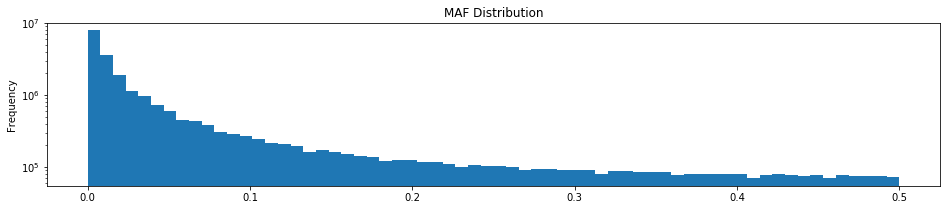

In [7]:
ax = pd.Series(
    hl.min(hl.variant_qc(mt_qc0).variant_qc.AF).collect()
).plot(kind='hist', bins=64)
ax.set_yscale('log')
ax.set_title('MAF Distribution')
plt.gcf().set_size_inches(16, 3)

In [6]:
%%timeop -o ps1

def qc_1(mt):
    # Filter call rates
    mt = hl.variant_qc(mt)
    mt = mt.filter_rows(mt.variant_qc.call_rate >= .8)
    mt = hl.sample_qc(mt)
    mt = mt.filter_cols(mt.sample_qc.call_rate >= .8)
    mt = hl.variant_qc(mt)
    mt = mt.filter_rows(mt.variant_qc.call_rate >= .98)
    mt = hl.sample_qc(mt)
    mt = mt.filter_cols(mt.sample_qc.call_rate >= .98)
    
    # Filter MAF
    mtv = hl.variant_qc(mt) 
    mtv = mtv.filter_rows(hl.min(mtv.variant_qc.AF) >= 0.05)    
    return mt.semi_join_rows(mtv.rows())

mt_qc1 = qc_1(mt_qc0)
mt_qc1.count()

(8240745, 629)

Elapsed time: 1207.4 seconds


(8240745, 629)

In [9]:
mt_qc1.write(osp.join(data_dir, PS1_1KG_QC_FILE + ".mt"), overwrite=True)

2020-01-19 01:55:25 Hail: INFO: wrote matrix table with 5808310 rows and 629 columns in 120 partitions to /home/eczech/data/gwas/tutorial/2_PS_GWAS/1KG_QC.mt


## Step 2: Prepare Datasets

##### Load 1KG

In [8]:
def get_1kg_pd():
    def get_race(pop):
        return dict(
            JPT='ASN', ASW='AFR', CEU='EUR', CHB='ASN', CHD='ASN', YRI='AFR', 
            LWK='AFR', TSI='EUR', MXL='AMR', GBR='EUR', FIN='EUR', CHS='ASN', PUR='AMR'
        ).get(pop, 'UNK')
    return pd.read_csv(osp.join(data_dir, '20100804.ALL.panel'), sep="\t", header=None, names=['s', 'pop', 'p1', 'p2'])\
        .assign(race=lambda df: df['pop'].apply(get_race)).drop(['p1', 'p2'], axis=1)
get_1kg_pd().head()

,s,pop,race
0,HG00098,GBR,EUR
1,HG00100,GBR,EUR
2,HG00106,GBR,EUR
3,HG00112,GBR,EUR
4,HG00114,GBR,EUR


The demographic information for the 1KG data is tab delimited but some lines contain 3 values instead of 4 (there should be 4 in every row).  Hail's ```import_table``` function can't handle this so first use pandas to re-write this data into a file with no malformed records after collapsing populations into less granular super populations:

In [9]:
get_1kg_pd().to_csv(osp.join(data_dir, '20100804.ALL.panel.clean'), sep="\t", index=False)

Now load it back out with Hail:

In [10]:
ht_1kg_pd = hl.import_table(osp.join(data_dir, '20100804.ALL.panel.clean'), delimiter="\t", key="s").drop('pop')
ht_1kg_pd.describe()

----------------------------------------
Global fields:
    None
----------------------------------------
Row fields:
    's': str 
    'race': str 
----------------------------------------
Key: ['s']
----------------------------------------


2020-01-21 18:13:56 Hail: INFO: Reading table with no type imputation
  Loading column 's' as type 'str' (type not specified)
  Loading column 'pop' as type 'str' (type not specified)
  Loading column 'race' as type 'str' (type not specified)



In [11]:
# Load the Hail MT from the previous step and attach the demographic info
mt_kg = hl.read_matrix_table(osp.join(data_dir, PS1_1KG_QC_FILE + ".mt")).drop("sample_qc", "variant_qc")
mt_kg = mt_kg.annotate_cols(race=ht_1kg_pd[mt_kg.s].race, source="1KG")
mt_kg = mt_kg.key_rows_by("rsid")
mt_kg = mt_kg.key_cols_by("source", "s")
mt_kg.describe()

----------------------------------------
Global fields:
    None
----------------------------------------
Column fields:
    's': str
    'fam_id': str
    'pat_id': str
    'mat_id': str
    'is_female': bool
    'is_case': bool
    'race': str
    'source': str
----------------------------------------
Row fields:
    'locus': locus<GRCh37>
    'alleles': array<str>
    'rsid': str
    'cm_position': float64
----------------------------------------
Entry fields:
    'GT': call
----------------------------------------
Column key: ['source', 's']
Row key: ['rsid']
----------------------------------------


In [12]:
mt_kg.count()

(5808310, 629)

##### Load HapMap

In [13]:
hl.ReferenceGenome(**hapmap3_hg18_rg())

ReferenceGenome(name=hapmap3_hg18, contigs=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '25'], lengths={'1': 247249719, '2': 242951149, '3': 199501827, '4': 191273063, '5': 180857866, '6': 170899992, '7': 158821424, '8': 146274826, '9': 140273252, '10': 135374737, '11': 134452384, '12': 132349534, '13': 114142980, '14': 106368585, '15': 100338915, '16': 88827254, '17': 78774742, '18': 76117153, '19': 63811651, '20': 62435964, '21': 46944323, '22': 49691432, '23': 154913754, '25': 154913754}, x_contigs=['23'], y_contigs=[], mt_contigs=[], par=[])

In [14]:
mt_hm = hl.import_plink(
    osp.join(data_dir, QC6_FILE + '.bed'),
    osp.join(data_dir, QC6_FILE + '.bim'),
    osp.join(data_dir, QC6_FILE + '.fam'),
    skip_invalid_loci=False,
    reference_genome='hapmap3_hg18'
)
# Add a race file to indicate ethnicity, which will be set here to a sentinel value
# as race for HapMap data is what is in question for this part of the tutorial.  The 
# source of the data will also be carried along (HMIII = HapMap Phase III)
mt_hm = mt_hm.annotate_cols(race='OWN', source='HMIII')
mt_hm = mt_hm.key_rows_by("rsid")
mt_hm = mt_hm.key_cols_by("source", "s")
mt_hm.describe()

----------------------------------------
Global fields:
    None
----------------------------------------
Column fields:
    's': str
    'fam_id': str
    'pat_id': str
    'mat_id': str
    'is_female': bool
    'is_case': bool
    'race': str
    'source': str
----------------------------------------
Row fields:
    'locus': locus<hapmap3_hg18>
    'alleles': array<str>
    'rsid': str
    'cm_position': float64
----------------------------------------
Entry fields:
    'GT': call
----------------------------------------
Column key: ['source', 's']
Row key: ['rsid']
----------------------------------------


2020-01-21 18:13:58 Hail: INFO: Found 109 samples in fam file.
2020-01-21 18:13:58 Hail: INFO: Found 1073226 variants in bim file.


In [15]:
mt_hm.count()

2020-01-21 18:14:01 Hail: INFO: Coerced sorted dataset


(1073226, 109)

##### Check Shared Individuals

The HapMap and 1KG datsets have some shared individuals.  This is why ```source``` is included as part of the key that defines a sample/individual above.

Inspect the intersection and differences between the individuals:

In [65]:
s_hm, s_kg = mt_hm.s.collect(), mt_kg.s.collect()
print('N Shared    :', len(np.intersect1d(s_hm, s_kg)), ' Ex: ', list(np.intersect1d(s_hm, s_kg)[:8]))
print('N HMIII Only:', len(np.setdiff1d(s_hm, s_kg)), ' Ex: ', list(np.setdiff1d(s_hm, s_kg)[:8]))
print('N 1KG Only  :', len(np.setdiff1d(s_kg, s_hm)), ' Ex: ', list(np.setdiff1d(s_kg, s_hm)[:8]))

N Shared    : 77  Ex:  ['NA06984', 'NA06985', 'NA06986', 'NA06989', 'NA06994', 'NA07000', 'NA07037', 'NA07051']
N HMIII Only: 32  Ex:  ['NA06993', 'NA07022', 'NA07031', 'NA07045', 'NA07055', 'NA07345', 'NA07435', 'NA11839']
N 1KG Only  : 552  Ex:  ['HG00098', 'HG00100', 'HG00106', 'HG00112', 'HG00114', 'HG00116', 'HG00117', 'HG00118']


2020-01-21 13:09:20 Hail: INFO: Coerced sorted dataset


## Step 3: Variant Liftover

There are 3 common reasons to need liftover ([source](https://genome.sph.umich.edu/wiki/LiftOver)):
    
- **Coordinate Liftover**: Convert genome position from one genome assembly to another genome assembly 
    - [Chain](https://genome.ucsc.edu/goldenPath/help/chain.html) files necessary for doing this can be found [here](http://hgdownload.soe.ucsc.edu/downloads.html#source_downloads)
- **Variant Liftover**: Convert dbSNP rs number from one build to another
- Both coordinate and variant liftover

The need for any of the above depends on the application and in this case we only need variant liftover.  It might seem that this is possible with the Hail [liftover](https://hail.is/docs/0.2/guides/genetics.html#liftover-variants-from-one-coordinate-system-to-another) function, but surprisingly it is not.  This function can only be used for coordinate liftover and in this case, we only care about determining which variants are the same in the HapMap and 1KG datasets based on id.  

The original tutorial goes through the process of trying to resolve strand conflicts between variants in separate builds as well as doing a manual liftover by assigning coordinates of variants based on an id to coordinate mapping, but all of this is only necessary because the PLINK command that ultimately merges the two datasets requires that the coordinates and allele definitions associated with a variant id do not conflict.  Population stratification will not require that alleles and coordinates align, it will only require a correspondence between variant ids.  We will exploit this in this tutorial to simplify the logic considerably.  The disadvantage of this is that some variants are truly not compatible between reference builds and should drop out of the analysis, but the original tutorial only finds ~80 such variants (this happens when a variant has A/T alleles in one dataset and C/G alleles in the other).  This will make little difference in a dimensionality reduction method like this involving millions of variants, as will be shown by attaining the same result as the original tutorial.


In [16]:
def get_allele_info(mt_hm, mt_kg):
    ht1, ht2 = mt_hm.rows(), mt_kg.rows()
    ht1 = ht1.key_by("rsid")
    ht1 = ht1.select(alleles=ht1.alleles[0] + ht1.alleles[1]).rename({'alleles': 'hm_alleles'})
    ht2 = ht2.key_by("rsid")
    ht2 = ht2.select(alleles=ht2.alleles[0] + ht2.alleles[1]).rename({'alleles': 'kg_alleles'})
    return ht1.join(ht2)

def get_allele_info_counts(ht):
    cts = ht.aggregate(hl.agg.counter(hl.struct(hm_alleles=ht.hm_alleles, kg_alleles=ht.kg_alleles)))
    return (
        pd.DataFrame([{**k, **{'count': v}} for k, v in cts.items()])
        .pivot(index='hm_alleles', columns='kg_alleles', values='count')
        .fillna(0).astype(int)
    )

In [167]:
ht_ai = get_allele_info(mt_hm, mt_kg)
get_allele_info_counts(ht_ai).style.background_gradient()

2020-01-21 17:41:31 Hail: INFO: Coerced sorted dataset
2020-01-21 17:41:32 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-01-21 17:41:33 Hail: INFO: Ordering unsorted dataset with network shuffle


kg_alleles,AC,AG,AT,CA,CG,CT,GA,GC,GT,TA,TC,TG
hm_alleles,,,,,,,,,,,,
AC,37018,3,0,4697,0,0,0,0,3,0,0,32
AG,4,158080,1,0,0,19,20425,0,1,0,141,0
AT,0,0,14194,0,0,0,0,0,0,1663,0,0
CA,4404,0,0,40192,1,5,0,1,37,0,0,1
CG,0,0,0,0,20673,0,0,2428,0,0,0,0
CT,0,15,0,0,2,178160,144,0,0,0,18431,0
GA,0,18171,0,0,0,131,177760,1,8,0,17,0
GC,0,0,0,0,2434,0,1,20583,1,0,0,0
GT,2,0,0,27,0,1,4,0,39760,0,0,4353


TODO: Explain this classification

In [18]:
ht_ai = ht_ai.annotate(
    classification=hl.case()
    .when(ht_ai.hm_alleles == ht_ai.kg_alleles, 'same')
    .when(ht_ai.hm_alleles == ht_ai.kg_alleles.reverse(), 'ref_swap')
    .when(ht_ai.hm_alleles == hl.reverse_complement(ht_ai.kg_alleles).reverse(), 'strand_swap')
    .when(ht_ai.hm_alleles == hl.reverse_complement(ht_ai.kg_alleles), 'ref_swap+strand_swap')
    .default('other')
)

In [170]:
pd.DataFrame(
    ht_ai
    .group_by(ht_ai.classification, ht_ai.hm_alleles, ht_ai.kg_alleles)
    .aggregate(count=hl.agg.count())
    .collect()
).sort_values('count', ascending=False)

2020-01-21 17:50:15 Hail: INFO: Coerced sorted dataset
2020-01-21 17:50:16 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-01-21 17:50:17 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-01-21 17:50:43 Hail: INFO: Ordering unsorted dataset with network shuffle


,classification,count,hm_alleles,kg_alleles
43,same,178160,CT,CT
44,same,177760,GA,GA
48,same,158641,TC,TC
39,same,158080,AG,AG
41,same,40192,CA,CA
46,same,39760,GT,GT
49,same,37179,TG,TG
38,same,37018,AC,AC
42,same,20673,CG,CG
45,same,20583,GC,GC


In [19]:
def invert_calls(mt, ai):
    mt = mt.annotate_rows(classification=ai[mt.rsid].classification)
    swap_classes = hl.set(['ref_swap', 'ref_swap+strand_swap'])
    return mt.annotate_entries(
        GT=hl.case()
        .when(
            swap_classes.contains(mt.classification), 
            hl.unphased_diploid_gt_index_call(2 - mt.GT.n_alt_alleles())
        ).default(mt.GT)
    )
    
mt_hm_lo = invert_calls(mt_hm, ht_ai)

In [22]:
# Make sure no variants or samples were lost in the liftover
cts = (mt_hm.count(), mt_hm_lo.count())
assert cts[0] == cts[1]
cts[1]

2020-01-21 18:15:15 Hail: INFO: Coerced sorted dataset
2020-01-21 18:15:19 Hail: INFO: Coerced sorted dataset


(1073226, 109)

In [23]:
mt_kg.write(osp.join(data_dir, PS3_1KG_FILE + ".mt"), overwrite=True)

2020-01-21 18:15:42 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-01-21 18:18:40 Hail: INFO: wrote matrix table with 5808310 rows and 629 columns in 118 partitions to /home/eczech/data/gwas/tutorial/2_PS_GWAS/Hail_1KG_Prep.mt


In [175]:
mt_hm_lo.write(osp.join(data_dir, PS3_HM_FILE + ".mt"), overwrite=True)

2020-01-21 17:55:59 Hail: INFO: Coerced sorted dataset
2020-01-21 17:56:03 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-01-21 17:56:06 Hail: INFO: Coerced sorted dataset
2020-01-21 17:56:07 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-01-21 17:56:08 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-01-21 17:58:33 Hail: INFO: wrote matrix table with 1073226 rows and 109 columns in 2 partitions to /home/eczech/data/gwas/tutorial/2_PS_GWAS/HMIII_LIFTOVER.mt


## Step 4: Merge Datasets

This step needs to combine the 1KG and HapMap data based on variant id.  This can be done easily in Hail with the [union_cols](https://hail.is/docs/0.2/hail.MatrixTable.html?highlight=union_cols#hail.MatrixTable.union_cols) function.

##### Combine

Merge the datasets column-wise where the rows will be matched based on the row keys shown above:

In [26]:
mt_kg = hl.read_matrix_table(osp.join(data_dir, PS3_1KG_FILE + ".mt"))

In [33]:
mt_hm_lo = hl.read_matrix_table(osp.join(data_dir, PS3_HM_FILE + ".mt"))

In [34]:
%%timeop -o ps2
# Note here that according to the docs "The row fields in the resulting dataset are the row fields from the
# first dataset" meaning that aside from rsid, no data about the variants that get merged needs to be equal
# and whatever other values for contig/chromosome, locus, and ref/alt allele will come from the HapMap data
mt_mg = mt_hm_lo.union_cols(mt_kg.annotate_rows(original_alleles=mt_kg.alleles), row_join_type='inner')
mt_mg.count()

(1000993, 738)

Elapsed time: 4.7 seconds


(1000993, 738)

In [35]:
mt_mg.describe()

----------------------------------------
Global fields:
    None
----------------------------------------
Column fields:
    's': str
    'fam_id': str
    'pat_id': str
    'mat_id': str
    'is_female': bool
    'is_case': bool
    'race': str
    'source': str
----------------------------------------
Row fields:
    'locus': locus<hapmap3_hg18>
    'alleles': array<str>
    'rsid': str
    'cm_position': float64
    'classification': str
----------------------------------------
Entry fields:
    'GT': call
----------------------------------------
Column key: ['source', 's']
Row key: ['rsid']
----------------------------------------


In [38]:
mt_mg.write(osp.join(data_dir, PS4_MERGE_FILE + '.mt'), overwrite=True)

2020-01-21 18:23:08 Hail: INFO: wrote matrix table with 1000993 rows and 738 columns in 118 partitions to /home/eczech/data/gwas/tutorial/2_PS_GWAS/Hail_1KG_HapMap_Merge.mt


## Step 5: Population Structure Projection

This step will show how the compatibility of the HapMap population with 1KG populations can be assessed.  It will do this by subsetting our merged dataset to only pruned (i.e. independent) variants and then running a dimensionality reduction algorithm to visualize how similar the 1KG European population is the putative European HapMap population.

Load the merged but unpruned dataset:

In [40]:
mt_mg = hl.read_matrix_table(osp.join(data_dir, PS4_MERGE_FILE + '.mt')).key_rows_by('rsid')
mt_mg.describe()

# TODO: remove me
# mt_mg = hl.import_plink(
#     osp.join(data_dir, 'MDS_merge2.bed'),
#     osp.join(data_dir, 'MDS_merge2.bim'),
#     osp.join(data_dir, 'MDS_merge2.fam'),
#     skip_invalid_loci=False,
#     reference_genome='hapmap3_hg18'
# ).key_rows_by('rsid')
# mt_mg = mt_mg.annotate_cols(source=hl.case().when(mt_mg.fam_id == mt_mg.s, "1KG").default("HMIII"))
# mt_mg = mt_mg.annotate_cols(race=hl.case().when(mt_mg.source == "1KG", ht_1kg_pd[mt_mg.s].race).default("OWN"))
# mt_mg = mt_mg.key_cols_by("source", "s")
# mt_mg.describe()

----------------------------------------
Global fields:
    None
----------------------------------------
Column fields:
    's': str
    'fam_id': str
    'pat_id': str
    'mat_id': str
    'is_female': bool
    'is_case': bool
    'race': str
    'source': str
----------------------------------------
Row fields:
    'locus': locus<hapmap3_hg18>
    'alleles': array<str>
    'rsid': str
    'cm_position': float64
    'classification': str
----------------------------------------
Entry fields:
    'GT': call
----------------------------------------
Column key: ['source', 's']
Row key: ['rsid']
----------------------------------------


In [41]:
mt_mg.aggregate_cols(hl.agg.counter(mt_mg.race))

{'ASN': 177, 'OWN': 109, 'AFR': 169, 'AMR': 22, 'EUR': 261}

In [42]:
mt_mg.count()

(1000993, 738)

Load the pruned variant table from the QC tutorial to be used as a filter:

In [51]:
# ht_var = hl.read_table(osp.join(prev_dir, QC5_PRUNED_VARIANTS_FILE + '.ht')).drop("variant_qc").key_by('rsid')
# ht_var.describe()

# TODO: remove below
# For comparison to PLINK results, using this set of pruned variants instead can be helfpul
ht_var = hl.import_table(osp.join(prev_dir, 'indepSNP.prune.in'), no_header=True).rename({'f0': 'rsid'}).key_by("rsid")

# Use PLINK variants directly from dataset
# # plink --bfile MDS_merge2 --extract indepSNP.prune.in --make-bed --out /tmp/MDS_merge2_extract
# ht_var = hl.import_table('/tmp/MDS_merge2_extract.bim', delimiter='\t', no_header=True).rename({'f1': 'rsid'})\
#     .drop("f0", "f2", "f3", "f4", "f5").key_by("rsid")

2020-01-21 18:29:30 Hail: INFO: Reading table with no type imputation
  Loading column 'f0' as type 'str' (type not specified)



In [52]:
ht_var.count()

104144

Filter to only pruned variants in the merged data (both must be keyed by rsid alone):

In [53]:
mt_mg_pr = mt_mg.semi_join_rows(ht_var)
mt_mg_pr.count()

2020-01-21 18:29:38 Hail: INFO: Ordering unsorted dataset with network shuffle


(93335, 738)

In [54]:
# As a preliminary check, look at the call rate status betweeen 1KG and HMIII samples
mt_mg_pr_cols = hl.sample_qc(mt_mg_pr.key_rows_by("locus", "alleles")).cols()
mt_mg_pr_cols.group_by(mt_mg_pr_cols.source).aggregate(stats=hl.agg.stats(mt_mg_pr_cols.sample_qc.call_rate)).show()

2020-01-21 18:29:39 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-01-21 18:29:41 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-01-21 18:29:42 Hail: INFO: Coerced sorted dataset


source,stats.mean,stats.stdev,stats.min,stats.max,stats.n,stats.sum
str,float64,float64,float64,float64,int64,float64
"""1KG""",9.99e-01,2.02e-03,9.81e-01,1.00e+00,629,6.29e+02
"""HMIII""",9.98e-01,2.57e-03,9.82e-01,1.00e+00,109,1.09e+02


##### Dimensionality Reduction

In [55]:
# Run PCA
# See: https://hail.is/docs/0.2/tutorials/01-genome-wide-association-study.html
eigenvalues, pcs, loadings = hl.hwe_normalized_pca(mt_mg_pr.GT, k=10, compute_loadings=True)
pcs.show(5, width=100)

2020-01-21 18:29:43 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-01-21 18:29:45 Hail: INFO: hwe_normalized_pca: running PCA using 93335 variants.
2020-01-21 18:29:45 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-01-21 18:29:48 Hail: INFO: pca: running PCA with 10 components...
2020-01-21 18:30:41 Hail: INFO: Coerced sorted dataset


source,s,scores
str,str,array<float64>
"""1KG""","""HG00098""","[-2.00e-01,1.90e-01,1.96e-02,1.74e-03,-5.71e-03,1.14e-03,5.39e-04,8.32e-03,3.70e-03,-1.39e-04]"
"""1KG""","""HG00100""","[-2.07e-01,1.96e-01,1.70e-02,-3.11e-03,-1.48e-02,-2.55e-03,-1.54e-03,3.27e-03,1.13e-03,3.97e-03]"
"""1KG""","""HG00106""","[-2.04e-01,1.93e-01,2.15e-02,-5.69e-03,5.05e-03,3.10e-04,-1.56e-02,1.70e-02,1.08e-02,-4.24e-03]"
"""1KG""","""HG00112""","[-2.13e-01,1.98e-01,3.17e-02,4.35e-03,3.69e-03,-2.09e-03,-8.85e-03,1.28e-02,-7.13e-04,3.94e-03]"
"""1KG""","""HG00114""","[-2.00e-01,1.88e-01,1.69e-03,-1.97e-04,1.68e-03,-1.60e-04,-1.78e-03,1.37e-02,3.36e-03,-4.46e-03]"


In [56]:
# Convert to pandas
def get_pca_data(mt, pcs):
    mt = mt.annotate_cols(scores = pcs[(mt.source, mt.s)].scores)
    return pd.DataFrame(hl.struct(source=mt.source, s=mt.s, race=mt.race, PC1=mt.scores[0], PC2=mt.scores[1]).collect())
df_pca = get_pca_data(mt_mg_pr, pcs)
df_pca.head()

,PC1,PC2,race,s,source
0,-0.198013,0.195232,OWN,NA06989,HMIII
1,-0.200173,0.188231,OWN,NA11891,HMIII
2,-0.197197,0.204136,OWN,NA11843,HMIII
3,-0.189178,0.193970,OWN,NA12341,HMIII
4,-0.196459,0.195150,OWN,NA06984,HMIII


##### Visualize

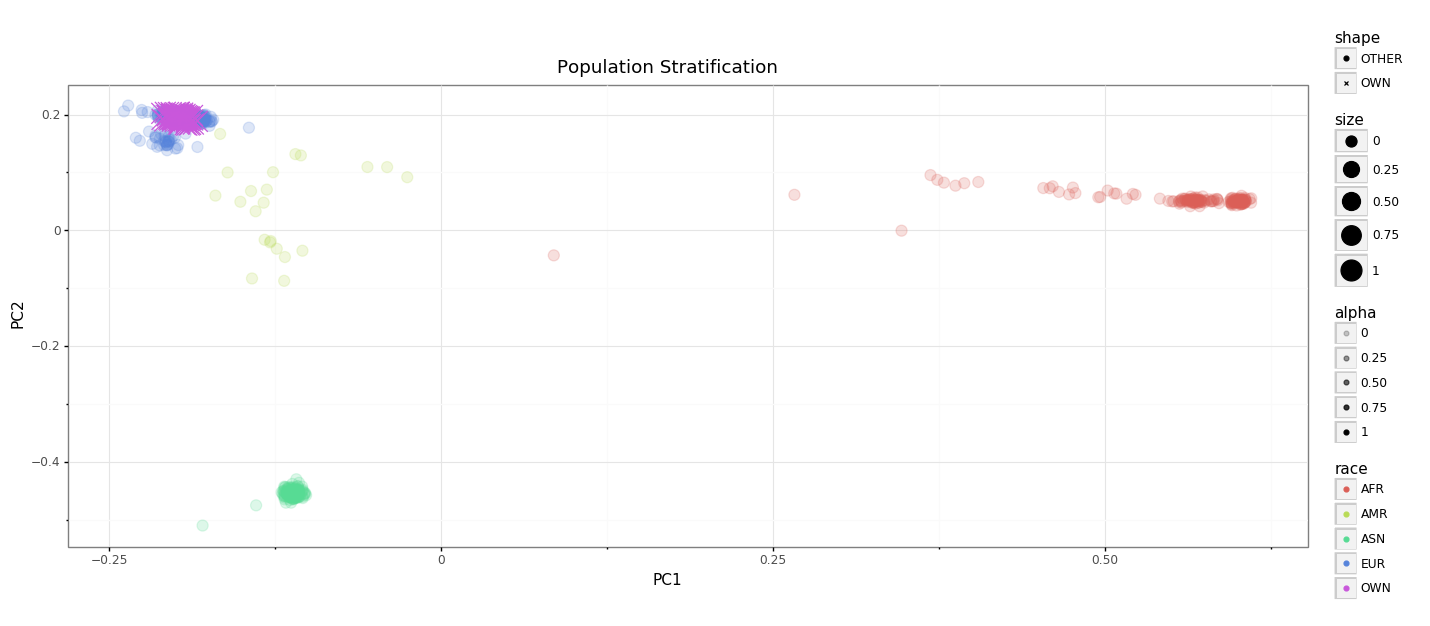

<ggplot: (8782051540905)>

In [57]:
# Show all the different 1KG populations superimposed on the HMIII population
def pca_plot(df):
    return (
        pn.ggplot(
            df
                .assign(alpha=lambda df: df['source'].apply(lambda v: 1 if v == 'HMIII' else 0))
                .assign(size=lambda df: df['race'].apply(lambda v: 1 if v == 'OWN' else 0))
                .assign(shape=lambda df: df['race'].apply(lambda v: 'OWN' if v == 'OWN' else 'OTHER'))
            , 
            pn.aes(x='PC1', y='PC2', fill='race', color='race', shape='shape', alpha='alpha', size='size')
        ) +
        pn.geom_point() + 
        pn.scale_shape_manual(values=['o', 'x']) +
        pn.scale_size_continuous(range=(4, 8)) + 
        pn.scale_alpha_continuous(range=(.2, 1)) +
        pn.theme_bw() +
        pn.labs(title='Population Stratification') + 
        pn.theme(figure_size=(16, 6)) 
    )
pca_plot(df_pca)

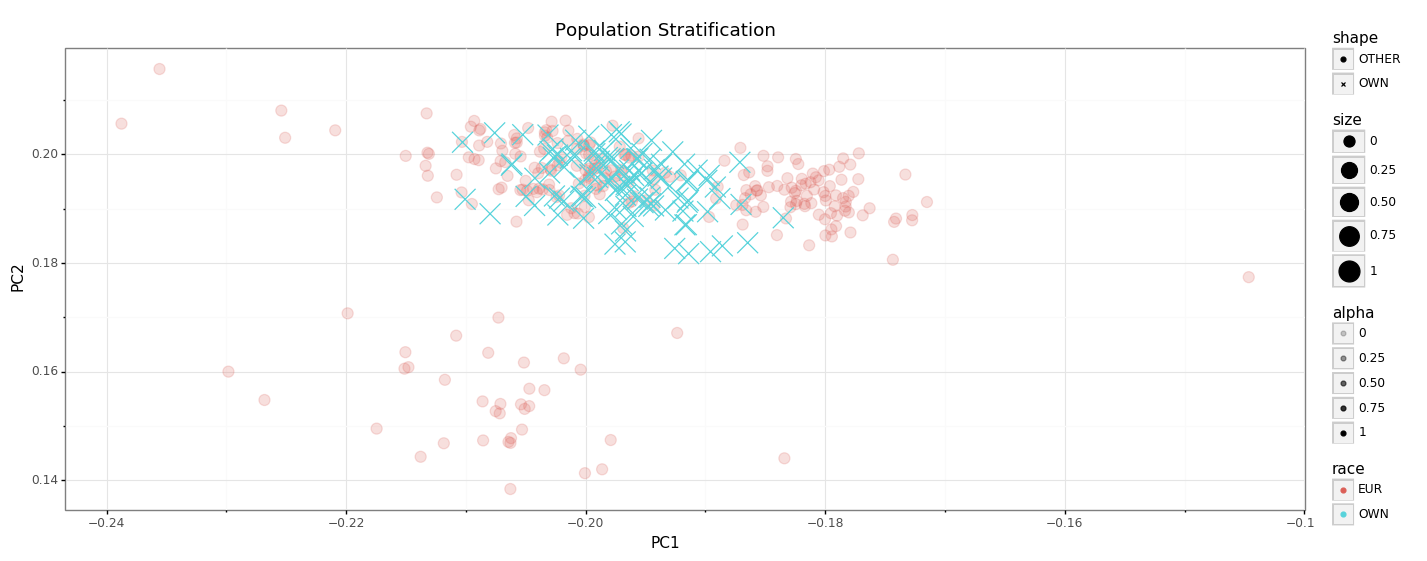

<ggplot: (8782052749805)>

In [58]:
# Zoom in on OWN + EUR populations 
pca_plot(df_pca.pipe(lambda df: df[df['race'].isin(['OWN', 'EUR'])]))

##### Run PLINK PCA on this data

In [420]:
hl.export_plink(
    mt_mg_pr
        .annotate_cols(sample_id=mt_mg_pr.source + '_' + mt_mg_pr.s)
        .key_rows_by("locus", "alleles")
        .key_cols_by("sample_id"), 
    '/tmp/mt_mg_pr'
)

2020-01-21 01:45:39 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-01-21 01:45:41 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-01-21 01:45:45 Hail: INFO: merging 119 files totalling 16.5M...
2020-01-21 01:45:45 Hail: INFO: while writing:
    /tmp/mt_mg_pr.bed
  merge time: 45.493ms
2020-01-21 01:45:45 Hail: INFO: merging 118 files totalling 3.1M...
2020-01-21 01:45:45 Hail: INFO: while writing:
    /tmp/mt_mg_pr.bim
  merge time: 31.490ms
2020-01-21 01:45:45 Hail: INFO: merging 16 files totalling 16.8K...
2020-01-21 01:45:45 Hail: INFO: while writing:
    /tmp/mt_mg_pr.fam
  merge time: 6.526ms
2020-01-21 01:45:45 Hail: INFO: wrote 93335 variants and 738 samples to '/tmp/mt_mg_pr'


In [421]:
%%bash
set -e; cd /tmp
plink --bfile mt_mg_pr --pca 10 header --out mt_mg_pr_pca

PLINK v1.90b6.14 64-bit (7 Jan 2020)           www.cog-genomics.org/plink/1.9/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to mt_mg_pr_pca.log.
Options in effect:
  --bfile mt_mg_pr
  --out mt_mg_pr_pca
  --pca 10 header

128535 MB RAM detected; reserving 64267 MB for main workspace.
93335 variants loaded from .bim file.
738 people (0 males, 0 females, 738 ambiguous) loaded from .fam.
Ambiguous sex IDs written to mt_mg_pr_pca.nosex .
Using up to 15 threads (change this with --threads).
Before main variant filters, 738 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotyping rate is 0.99925.
93335 variants and 738 people pass filters and QC.
Note: No phenotypes present.
Relationship matrix calculation complete.
--pca: Results saved 

In [422]:
%%bash
set -e; cd /tmp
head mt_mg_pr_pca.eigenvec

FID IID PC1 PC2 PC3 PC4 PC5 PC6 PC7 PC8 PC9 PC10
0 HMIII_NA06989 0.0168389 -0.0248504 0.0863474 -0.00122049 -0.0134243 0.00817535 0.00775196 -0.253291 -0.160394 -0.0639024
0 HMIII_NA11891 0.0172464 -0.0240587 0.078919 -0.00602797 -0.016469 0.00696353 -0.00338809 0.000321956 -0.00956285 0.0115754
0 HMIII_NA11843 0.0164585 -0.0253791 0.0830369 -0.0140458 -0.00787939 0.00664045 0.00892492 0.0111192 0.0842407 -0.120475
0 HMIII_NA12341 0.0159153 -0.0240716 0.0705605 0.00537012 -0.00927252 -0.000576456 -0.00479464 -0.00608734 -0.120431 -0.0192395
0 HMIII_NA06984 0.0166759 -0.0239175 0.0781587 -0.000973434 -0.0180189 -0.00769736 -0.0172295 -0.0255456 0.0699085 -0.0788147
0 HMIII_NA12275 0.016598 -0.0239292 0.0755536 -0.000998881 -0.0129286 -0.0033325 0.00908252 0.110788 -0.122347 0.0946739
0 HMIII_NA06986 0.0160934 -0.0237473 0.0857315 -0.0125533 -0.0119087 -0.010063 -0.00526026 -0.00120169 0.136358 -0.1092
0 HMIII_NA12272 0.0166765 -0.0236396 0.0700294 -0.00365157 -0.0174888 0.00219318 -0.00

In [423]:
df_pca.head()

,PC1,PC2,race,s,source
0,-0.140195,-0.173608,OWN,NA06989,HMIII
1,-0.142285,-0.166544,OWN,NA11891,HMIII
2,-0.137240,-0.177581,OWN,NA11843,HMIII
3,-0.132395,-0.168029,OWN,NA12341,HMIII
4,-0.138419,-0.166587,OWN,NA06984,HMIII


In [425]:
df_tmp_pca = (
    pd.read_csv('/tmp/mt_mg_pr_pca.eigenvec', sep='\s+')
    .assign(race=lambda df: df['IID'].map(df_pca.assign(sample_id=lambda df: df['source'] + '_' + df['s']).set_index('sample_id')['race'].to_dict()))
    .assign(source=lambda df: df['IID'].str.split('_').str[0])
    .assign(s=lambda df: df['IID'].str.split('_').str[1])
)
df_tmp_pca.head()

,FID,IID,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,race,source,s
0,0,HMIII_NA06989,0.016839,-0.024850,0.086347,-0.001220,-0.013424,0.008175,0.007752,-0.253291,-0.160394,-0.063902,OWN,HMIII,NA06989
1,0,HMIII_NA11891,0.017246,-0.024059,0.078919,-0.006028,-0.016469,0.006964,-0.003388,0.000322,-0.009563,0.011575,OWN,HMIII,NA11891
2,0,HMIII_NA11843,0.016459,-0.025379,0.083037,-0.014046,-0.007879,0.006640,0.008925,0.011119,0.084241,-0.120475,OWN,HMIII,NA11843
3,0,HMIII_NA12341,0.015915,-0.024072,0.070560,0.005370,-0.009273,-0.000576,-0.004795,-0.006087,-0.120431,-0.019239,OWN,HMIII,NA12341
4,0,HMIII_NA06984,0.016676,-0.023918,0.078159,-0.000973,-0.018019,-0.007697,-0.017229,-0.025546,0.069908,-0.078815,OWN,HMIII,NA06984


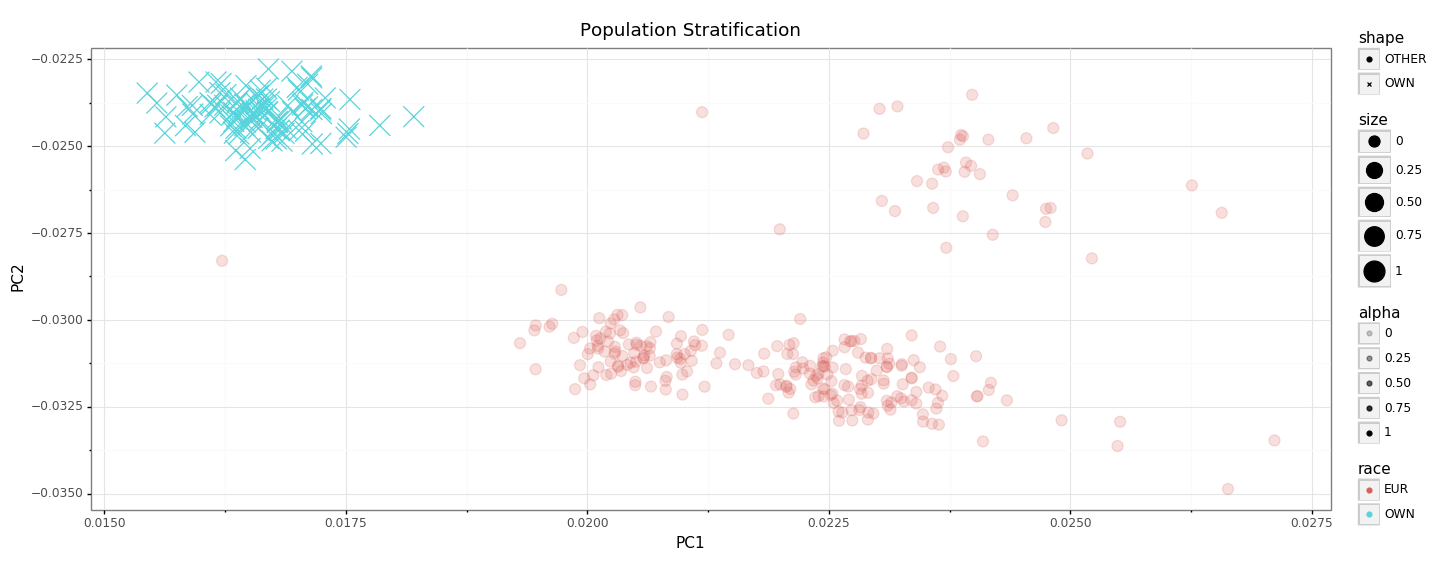

<ggplot: (8784915649117)>

In [427]:
# Zoom in on OWN + EUR populations 
pca_plot(df_tmp_pca.pipe(lambda df: df[df['race'].isin(['OWN', 'EUR'])]))

### Assessment

The results above make sense for the most part, but the HapMap simples still end up more distant than expected from the 1KG EUR samples in the 2D projection as compared to the same result from PLINK.  The HapMap population can still be filtered with other EUR samples using a manual threshold, but this minor discrepancy will be studied further below by trying to emulate what PLINK is doing more closely.  

PCA (HWE normalize) was used above on the call matrix directly while in PLINK MDS is run using IBS (identity-by-descent) as a distance measure.  The closest we can get to that with Hail is shown below, where a ```genetic_relatedness_matrix``` is computed and used in a scikit-learn MDS implementation to attain a projection more similar to the one from PLINK.

In [392]:
# Resulting GRM values can be positive or negative and are higher for more closely related individuals
grm = hl.genetic_relatedness_matrix(mt_mg_pr.GT).to_numpy()
grm.shape

2020-01-21 00:44:17 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-01-21 00:44:23 Hail: INFO: Wrote all 23 blocks of 93335 x 738 matrix with block size 4096.


(738, 738)

In [393]:
mat_stats(grm, axis=None)

DescribeResult(nobs=544644, minmax=(-0.14713119032938785, 1.2692592494597625), mean=5.74666655708694e-16, variance=0.014589258575627985, skewness=2.1293274140997642, kurtosis=9.792362379728425)

In [364]:
np.round(grm[:5, :5], 3)

array([[1.027, 0.054, 0.049, 0.058, 0.055],
       [0.054, 1.017, 0.056, 0.056, 0.055],
       [0.049, 0.056, 1.036, 0.049, 0.059],
       [0.058, 0.056, 0.049, 1.022, 0.052],
       [0.055, 0.055, 0.059, 0.052, 1.024]])

In [397]:
from sklearn.manifold import MDS
mds = MDS(n_components=10, metric=True, eps=1e-8, max_iter=int(1e6), dissimilarity='precomputed', random_state=1)
mds = mds.fit_transform((1 - np.clip(grm, -1, 1))/2)
mds.shape

(738, 10)

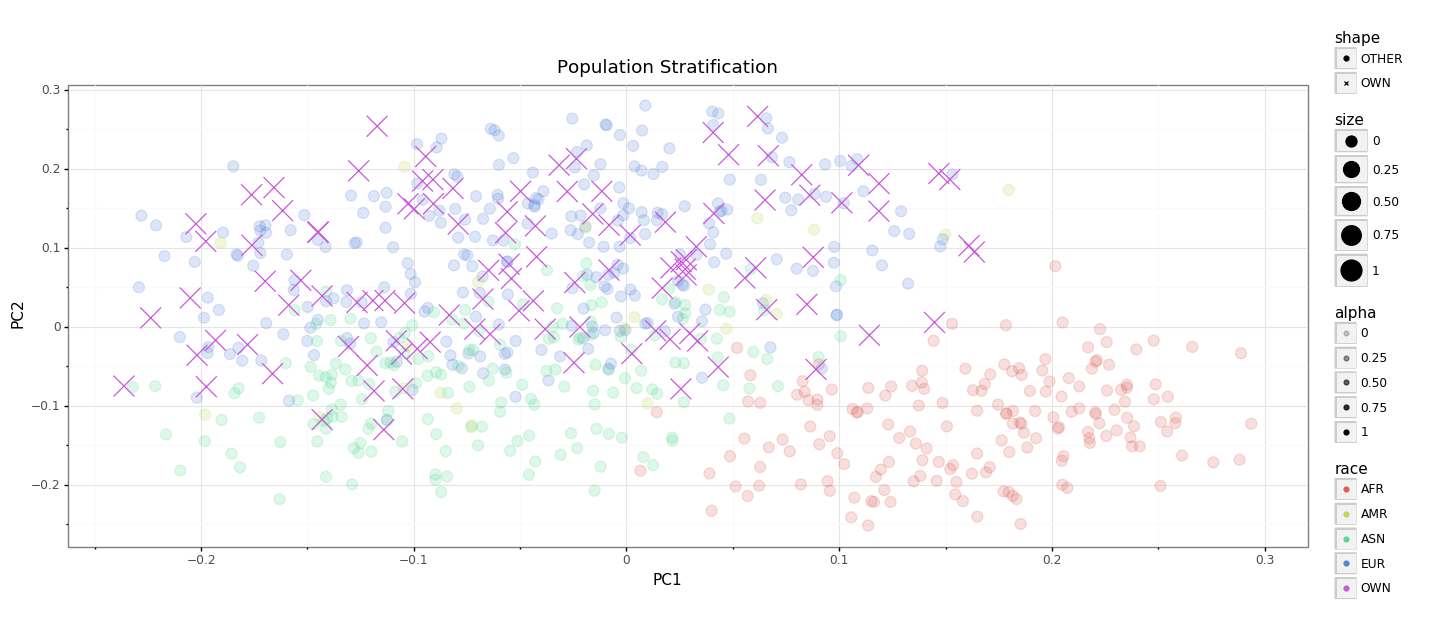

<ggplot: (8784914535461)>

In [398]:
pca_plot(
    pd.DataFrame(hl.struct(source=mt_mg_pr.source, s=mt_mg_pr.s, race=mt_mg_pr.race).collect())
    .assign(PC1=mds[:,0], PC2=mds[:,1])
)

#### IBS

In [228]:
mt_mg_pr.annotate_cols(sample_id=mt_mg_pr.source + '_' + mt_mg_pr.s).key_cols_by('sample_id').describe()

----------------------------------------
Global fields:
    None
----------------------------------------
Column fields:
    's': str
    'fam_id': str
    'pat_id': str
    'mat_id': str
    'is_female': bool
    'is_case': bool
    'race': str
    'source': str
    'sample_id': str
----------------------------------------
Row fields:
    'locus': locus<hapmap3_hg18>
    'alleles': array<str>
    'rsid': str
    'cm_position': float64
----------------------------------------
Entry fields:
    'GT': call
----------------------------------------
Column key: ['sample_id']
Row key: ['rsid']
----------------------------------------


In [344]:
# IBS requires single column key for sample id
ibs = hl.identity_by_descent(
    mt_mg_pr
    .annotate_cols(sample_id=mt_mg_pr.source + '_' + mt_mg_pr.s)
    .key_cols_by('sample_id')
    .key_rows_by("locus", "alleles")
)
# Add distance measure as specified in https://www.cog-genomics.org/plink/1.9/ibd
ibs = ibs.annotate(dst=(ibs.ibs2 + 0.5*ibs.ibs1) / (ibs.ibs0 + ibs.ibs1 + ibs.ibs2))
ibs.describe()

----------------------------------------
Global fields:
    None
----------------------------------------
Row fields:
    'i': str 
    'j': str 
    'ibd': struct {
        Z0: float64, 
        Z1: float64, 
        Z2: float64, 
        PI_HAT: float64
    } 
    'ibs0': int64 
    'ibs1': int64 
    'ibs2': int64 
    'dst': float64 
----------------------------------------
Key: ['i', 'j']
----------------------------------------


In [345]:
df_ibs = pd.DataFrame(hl.struct(i=ibs.i, j=ibs.j, dst=ibs.dst).collect())
df_ibs.head()

2020-01-20 05:07:35 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-01-20 05:07:37 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-01-20 05:07:50 Hail: INFO: Ordering unsorted dataset with network shuffle


,dst,i,j
0,0.741825,1KG_HG00098,1KG_HG00100
1,0.741235,1KG_HG00098,1KG_HG00106
2,0.743746,1KG_HG00098,1KG_HG00112
3,0.741552,1KG_HG00098,1KG_HG00114
4,0.742020,1KG_HG00098,1KG_HG00116


In [355]:
df_ibs_p = df_ibs.pivot(index='i', columns='j', values='dst').fillna(0)
df_ibs_p += df_ibs_p.T.values
df_ibs_p += np.eye(df_ibs_p.shape[0])
df_ibs_p.head()

j,1KG_HG00098,1KG_HG00100,1KG_HG00106,1KG_HG00112,1KG_HG00114,1KG_HG00116,1KG_HG00117,1KG_HG00118,1KG_HG00119,1KG_HG00120,...,HMIII_NA12830,HMIII_NA12842,HMIII_NA12843,HMIII_NA12872,HMIII_NA12873,HMIII_NA12875,HMIII_NA12889,HMIII_NA12890,HMIII_NA12891,HMIII_NA12892
i,,,,,,,,,,,,,,,,,,,,,
1KG_HG00098,0.000000,0.741825,0.741235,0.743746,0.741552,0.742020,0.740575,0.743157,0.742290,0.744398,...,0.739369,0.737537,0.738969,0.738928,0.737673,0.739392,0.737871,0.738528,0.738153,0.738962
1KG_HG00100,0.741825,0.000000,0.735476,0.740087,0.736838,0.736870,0.735464,0.740568,0.737139,0.738662,...,0.734742,0.735337,0.735358,0.733368,0.733849,0.735172,0.734022,0.732451,0.734483,0.732904
1KG_HG00106,0.741235,0.735476,0.000000,0.736725,0.736046,0.735241,0.735663,0.737323,0.735831,0.738354,...,0.732659,0.734002,0.733763,0.733771,0.733609,0.733940,0.733180,0.733686,0.733392,0.734381
1KG_HG00112,0.743746,0.740087,0.736725,0.000000,0.735979,0.737783,0.735027,0.738459,0.739107,0.738396,...,0.735040,0.734389,0.734117,0.734306,0.734526,0.734328,0.733799,0.733049,0.734338,0.732951
1KG_HG00114,0.741552,0.736838,0.736046,0.735979,0.000000,0.736276,0.735136,0.736936,0.735390,0.740716,...,0.733665,0.734076,0.733401,0.733286,0.733116,0.733037,0.731602,0.732580,0.732650,0.733349


In [357]:
df_ibs_p.shape

(737, 737)

In [358]:
mat_stats(df_ibs_p.values, axis=None)

DescribeResult(nobs=543169, minmax=(0.0, 1.6935816150100378), mean=0.7158601777381649, variance=0.002914801803309037, skewness=3.4989117892544708, kurtosis=143.06791544189932)

In [359]:
from sklearn.manifold import MDS
mds = MDS(n_components=10, metric=True, dissimilarity='precomputed', random_state=1)
mds = mds.fit_transform(df_ibs_p.values)
mds.shape

(737, 10)

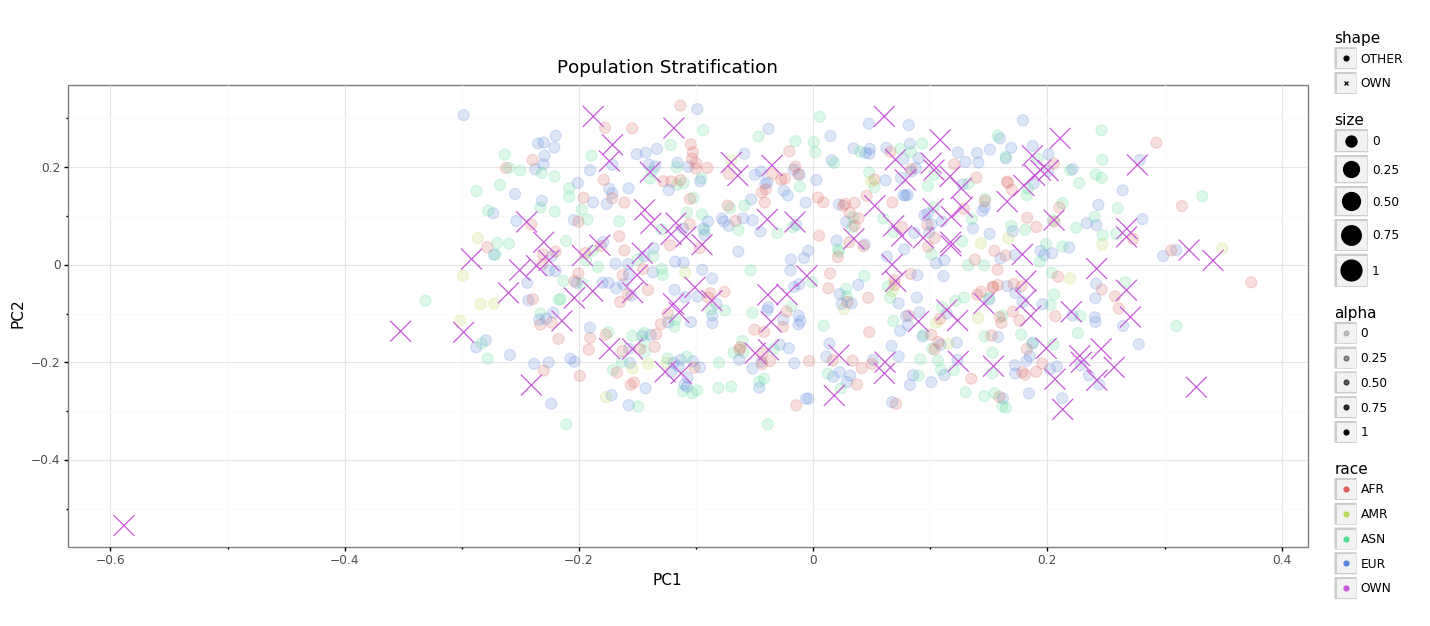

<ggplot: (8784912088613)>

In [360]:
m_race = df_pca.assign(sample_id=lambda df: df['source'].str.cat(df['s'], sep='_')).set_index('sample_id')['race'].to_dict()
pca_plot(
    pd.DataFrame(dict(sample_id=df_ibs_p.index.values))
    .assign(source=lambda df: df['sample_id'].str.split('_').str[0])
    .assign(s=lambda df: df['sample_id'].str.split('_').str[1])
    .assign(race=lambda df: df['sample_id'].map(m_race))
    .assign(PC1=mds[:,0], PC2=mds[:,1])
)